## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

In [101]:
### import necessary libraries
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

In [3]:
# nltk.download('punkt')
# ! pip install wordcloud

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json', 'r') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [6]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
df.columns = df.columns.str.removeprefix("_source.")
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [10]:
df.columns = df.columns.str.removeprefix("_")
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [11]:
df.rename(columns={'complaint_what_happened':'complaint'}, inplace=True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaint',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [12]:
#Assign nan in place of blanks in the complaints column
df['complaint'].count()

78313

In [13]:
df['complaint'].isnull().sum()

0

In [14]:
len(df[df['complaint']==''])

57241

In [15]:
df['complaint'].replace('', np.nan, inplace=True)
df['complaint'].isnull().sum()

57241

In [16]:
#Remove all rows where complaints column is nan
df.dropna(subset=["complaint"], inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [190]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[\w*\]', '', text) # Remove text in square brackets
    text = re.sub(r'[^\w\s]','',text) # Remove punctuation
    text = re.sub(r'\S*\d\S*', '', text) # Remove words containing numbers
    text = re.sub(r' +', ' ',text)
    return text

In [191]:
# clean_text("Hello Boss! , [how] are you r9ng 9rn 343 rng99 doing??")

In [19]:
%%time
# Applying the cleaning on complaints text
df['complaint'] = df['complaint'].apply(clean_text)
df['complaint'].head()

CPU times: total: 9.06 s
Wall time: 9.44 s


1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx xxxx ticket i c...
14    my grand son give me check for i deposit it in...
Name: complaint, dtype: object

In [20]:
#Write your function to Lemmatize the texts
def lemmatizate_text(text):
    tokens = word_tokenize(text)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_words = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_sent = " ".join(lemmatized_words)
    return lemmatized_sent

In [192]:
# lemmatizate_text("cleaning the brushes, finding is right, crying baby ")

In [22]:
%%time
df['complaint_lemma'] = df['complaint'].apply(lemmatizate_text)
df['complaint_lemma'].head()

CPU times: total: 58.6 s
Wall time: 1min


1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and wa told by...
10    chase card wa reported on however fraudulent a...
11    on while trying to book a xxxx xxxx ticket i c...
14    my grand son give me check for i deposit it in...
Name: complaint_lemma, dtype: object

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint','complaint_lemma']]

In [24]:
df_clean

,complaint,complaint_lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...


In [25]:
#Write your function to extract the POS tags

def get_nouns_pos_tag(text):
  # write your code here
    tokens = nlp(text)
    nouns = []
    for token in tokens:
        if(token.tag_ == 'NN'):
            nouns.append(token.text)
    nouns_sent = " ".join(nouns)
    return nouns_sent

In [26]:
get_nouns_pos_tag("A cat is chasing the rat..")

'cat rat'

In [27]:
%%time 
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['complaint_lemma'].apply(get_nouns_pos_tag)

CPU times: total: 9min 21s
Wall time: 12min 30s


In [28]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [29]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(c) for c in df['complaint']]

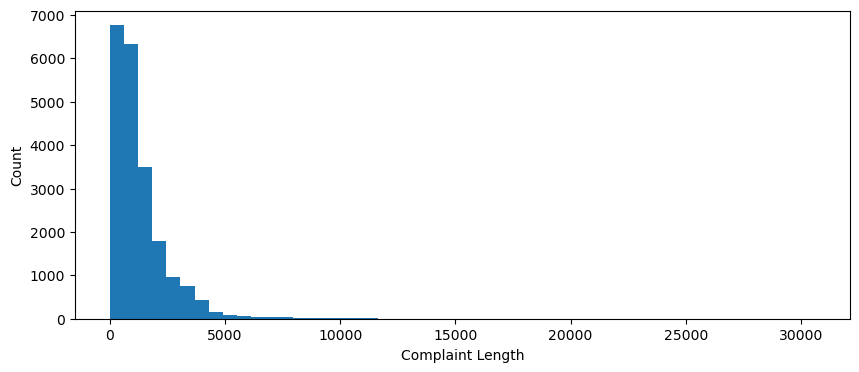

In [30]:
plt.figure(figsize=(10,4))
plt.hist(char_len, bins=50)
plt.xlabel('Complaint Length')
plt.ylabel('Count')
plt.show()

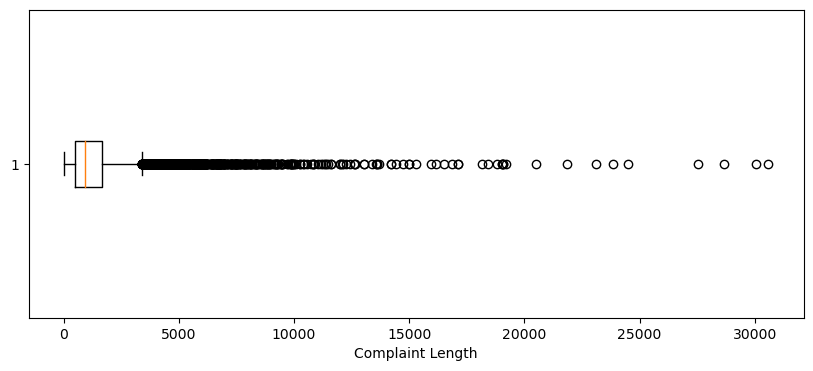

In [31]:
plt.figure(figsize=(10,4))
plt.boxplot(char_len, vert=False)
plt.xlabel('Complaint Length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

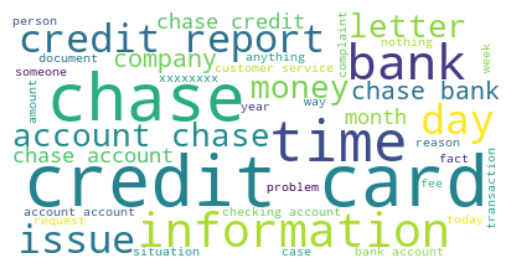

In [32]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
text = ' '.join(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(max_words=40, stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
print(wordcloud.words_.keys())

dict_keys(['credit card', 'chase', 'time', 'bank', 'information', 'day', 'credit report', 'issue', 'account chase', 'money', 'letter', 'chase bank', 'company', 'chase account', 'chase credit', 'month', 'customer service', 'year', 'nothing', 'document', 'account account', 'checking account', 'way', 'bank account', 'week', 'anything', 'reason', 'transaction', 'case', 'someone', 'person', 'today', 'xxxxxxxx', 'fee', 'fact', 'problem', 'request', 'amount', 'situation', 'complaint'])


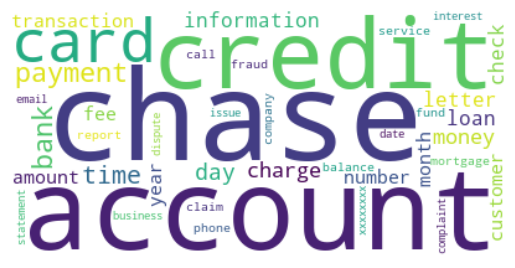

In [34]:
# Word cloud after setting collactions to False
stopwords = set(STOPWORDS)
text = ' '.join(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(max_words=40, stopwords=stopwords, background_color="white", collocations=False).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
print(wordcloud.words_.keys())

dict_keys(['chase', 'account', 'credit', 'card', 'payment', 'bank', 'time', 'day', 'charge', 'money', 'loan', 'check', 'information', 'letter', 'fee', 'number', 'transaction', 'month', 'amount', 'year', 'customer', 'mortgage', 'balance', 'company', 'service', 'phone', 'fund', 'report', 'claim', 'call', 'fraud', 'email', 'business', 'interest', 'issue', 'statement', 'dispute', 'xxxxxxxx', 'complaint', 'date'])


In [36]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [37]:
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [187]:
# Utility function to get ngrams as dataframe along with frequency
def get_word_freq(ngram):
    count_vec = CountVectorizer(stop_words='english', ngram_range=(ngram,ngram))
    grams = count_vec.fit_transform(df_clean['Complaint_clean'])
    vocab = count_vec.vocabulary_
    word_counts = grams.sum(axis=0)
    freq_words = sorted([(word_counts[0,index], word) for word, index in vocab.items()], reverse=True)
    df_freq = pd.DataFrame(freq_words)
    df_freq.rename(columns={0: 'frequency', 1:'word'}, inplace=True)
    return df_freq

In [156]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
df_unigram = get_word_freq(1)
df_unigram.head(30)

,frequency,word
0,59324,chase
1,46920,account
2,32546,credit
3,30163,card
4,21148,payment
5,20705,bank
6,16021,time
7,12917,day
8,11976,charge
9,11942,money


In [205]:
#Print the top 10 words in the unigram frequency
df_unigram['word'].head(10)

0      chase
1    account
2     credit
3       card
4    payment
5       bank
6       time
7        day
8     charge
9      money
Name: word, dtype: object

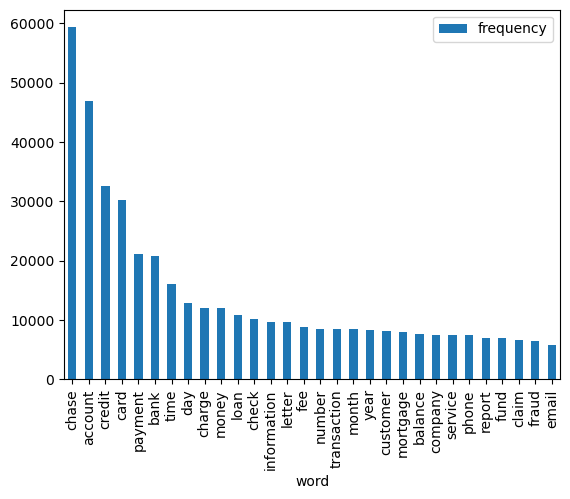

In [206]:
df_unigram_top30 = df_unigram.head(30)
df_unigram_top30.plot(x='word', y='frequency', kind='bar')
plt.show()

In [160]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
df_bigram = get_word_freq(2)
df_bigram.head(30)

,frequency,word
0,12844,credit card
1,3857,credit report
2,3753,account chase
3,3548,chase bank
4,3496,chase account
5,3373,chase credit
6,3056,customer service
7,2857,account account
8,2549,checking account
9,2542,bank account


In [203]:
#Print the top 10 words in the bigram frequency
df_bigram['word'].head(10)

0         credit card
1       credit report
2       account chase
3          chase bank
4       chase account
5        chase credit
6    customer service
7     account account
8    checking account
9        bank account
Name: word, dtype: object

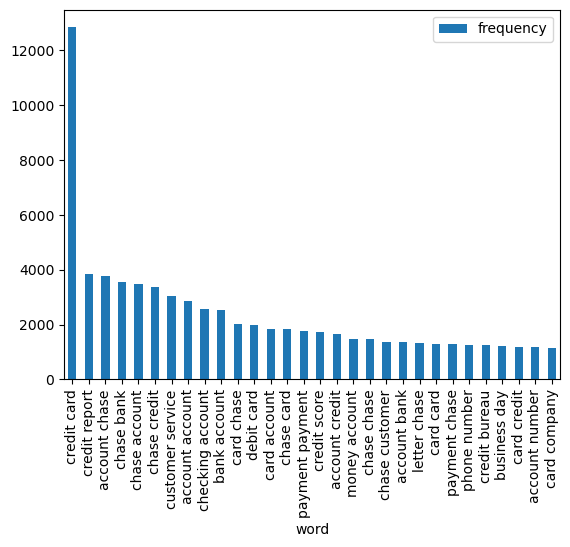

In [204]:
df_bigram_top30 = df_bigram.head(30)
df_bigram_top30.plot(x='word', y='frequency', kind='bar')
plt.show()

In [188]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
df_trigram = get_word_freq(3)
df_trigram.head(30)

,frequency,word
0,2244,chase credit card
1,1146,credit card account
2,1002,credit card company
3,901,credit card chase
4,626,chase customer service
5,583,credit card credit
6,552,inquiry credit report
7,478,card credit card
8,475,account credit card
9,456,chase bank account


In [189]:
#Print the top 10 words in the trigram frequency
df_trigram['word'].head(10)

0         chase credit card
1       credit card account
2       credit card company
3         credit card chase
4    chase customer service
5        credit card credit
6     inquiry credit report
7          card credit card
8       account credit card
9        chase bank account
Name: word, dtype: object

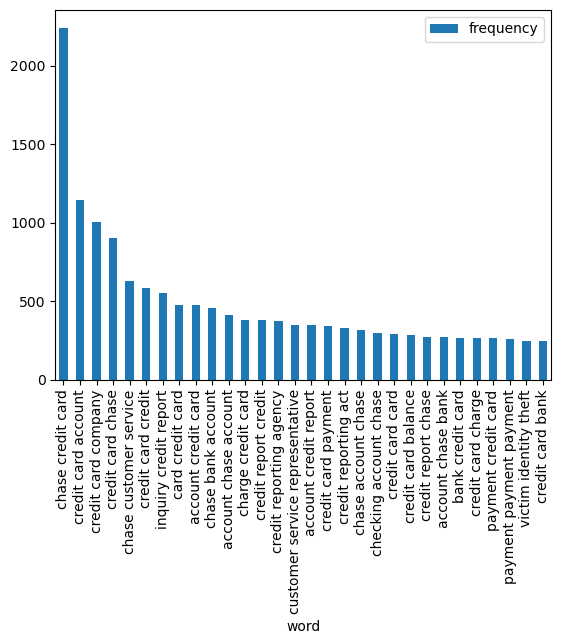

In [202]:
df_trigram_top30 = df_trigram.head(30)
df_trigram_top30.plot(x='word', y='frequency', kind='bar')
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [44]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('XXXX','')

In [45]:
#All masked texts has been removed
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [46]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [47]:
%%time
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

CPU times: total: 1.02 s
Wall time: 2.63 s


In [48]:
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names_out())

,aa,aarp,abandonment,abatement,abbreviation,abide,ability,absence,absent,absurdity,...,yield,yo,yoga,youth,yr,zilch,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.158255,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [49]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [50]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [51]:
%%time
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

CPU times: total: 1.05 s
Wall time: 2.57 s


6034

In [52]:
topic_terms = nmf_model.components_       # Topic-term matrix

In [53]:
#Print the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names_out())
top15_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = topic_terms[i].argsort()[::-1][:15]
    top15_words.iloc[i] = words[ix]

top15_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,day,deposit,branch,transaction,checking,number,fee,claim,business
Topic 2,card,charge,chase,credit,dispute,purchase,transaction,service,fraud,merchant,fee,time,balance,company,customer
Topic 3,payment,balance,fee,month,statement,day,time,date,chase,credit,auto,year,account,error,mortgage
Topic 4,credit,report,inquiry,card,account,score,bureau,company,debt,information,reporting,identity,application,theft,limit
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,time,document,rate,foreclosure,house,sale,information


In [54]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
doc_topics = nmf_model.transform(dtm)
doc_topics

array([[1.92590478e-02, 4.00656662e-04, 8.68844602e-03, 1.69008274e-02,
        2.27066277e-02],
       [7.82020971e-03, 1.51206527e-02, 2.02015106e-03, 2.09882715e-03,
        3.03098789e-03],
       [0.00000000e+00, 2.38005184e-02, 0.00000000e+00, 3.16745995e-02,
        0.00000000e+00],
       ...,
       [1.50218512e-02, 1.82049046e-02, 1.95541265e-05, 1.21710336e-02,
        1.16024421e-02],
       [0.00000000e+00, 6.32605717e-02, 1.02022366e-01, 6.60841982e-03,
        0.00000000e+00],
       [2.66239238e-02, 3.57654083e-03, 9.41741512e-02, 3.75155410e-02,
        0.00000000e+00]])

In [55]:
doc_topics.shape

(21072, 5)

In [56]:
doc_topics.argmax(axis=1)

array([4, 1, 3, ..., 1, 2, 2], dtype=int64)

In [57]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = doc_topics.argmax(axis=1) #write your code to assign topics to each rows.

In [58]:
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,4
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,1
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,3
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0


In [59]:
#Print the first 5 Complaint for each of the Topics
top5_complaints=df_clean.groupby('Topic').head(5)
top5_complaints.sort_values('Topic')

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account auto,account auto,0
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charged wron...,concern overdraft fee alert balance unsuficent...,concern overdraft fee alert balance unsuficent...,0
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,1
45,i made a purchase with xxxx xxxx xxxx on in th...,i made a purchase with xxxx xxxx xxxx on in th...,purchase amount transaction dispute case bank ...,purchase amount transaction dispute case bank ...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1
21,on xxxx i made a payment to an online retailer...,on xxxx i made a payment to an online retailer...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [60]:
#Create the dictionary of Topic names and Topics

topicnumber_name = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topicnumber_name)

In [61]:
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Credit card or prepaid card
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Credit card or prepaid card
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [62]:
#Create the dictionary again of Topic names and Topics

topicname_number = {
    'Bank Account services': 0,
    'Credit card or prepaid card': 1,
    'Others': 2,
    'Theft/Dispute Reporting': 3,
    'Mortgage/Loan': 4
}

#Replace Topic Names with Topics
df_clean['Topic'] = df_clean['Topic'].map(topicname_number)

In [63]:
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,4
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,card agent anniversary date agent wa informati...,1
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,3
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,1
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,1
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit yr credit card chase freedom problem ba...,credit yr credit card chase freedom problem ba...,2


In [64]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint', 'Topic']]

In [65]:
training_data

,complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,1
10,chase card was reported on however fraudulent ...,3
11,on while trying to book a xxxx xxxx ticket i c...,3
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,1
78310,i am not familiar with xxxx pay and did not un...,1
78311,i have had flawless credit for yrs ive had cha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [66]:
%%time
#Write your code to get the Vector count
countvec_model = CountVectorizer(stop_words='english')
word_vec = countvec_model.fit_transform(training_data['complaint'])
word_vec.shape

CPU times: total: 2.66 s
Wall time: 8.26 s


(21072, 33378)

In [67]:
%%time
#Write your code here to transform the word vector to tf-idf
tfidf_model = TfidfTransformer()
tfidf_vec = tfidf_model.fit_transform(word_vec)
tfidf_vec.shape

CPU times: total: 109 ms
Wall time: 112 ms


(21072, 33378)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, f1_score

In [69]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_vec, training_data['Topic'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((16857, 33378), (4215, 33378))

In [70]:
# Defining helper functions:
def eval_model(model):
    y_train_pred = model.predict(X_train)
    print("Train Data Results:")
    print("f1-score:", f1_score(y_true=y_train, y_pred=y_train_pred, average='weighted').round(2))
    print("Classification Report:")
    print(classification_report(y_true=y_train, y_pred=y_train_pred))
    y_test_pred = model.predict(X_test)
    print("Test Data Results:")
    print("f1-score:", f1_score(y_true=y_test, y_pred=y_test_pred, average='weighted').round(2))
    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_test_pred))

### 1. Logistic Regression

In [71]:
%%time
# Logistic Regression
lr = LogisticRegression()
lr_model = lr.fit(X_train, y_train)

CPU times: total: 4.06 s
Wall time: 18.7 s


In [72]:
eval_model(lr_model)

Train Data Results:
f1-score: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4637
           1       0.97      0.99      0.98      4870
           2       0.99      0.95      0.97      2018
           3       0.98      0.95      0.96      2146
           4       0.98      0.97      0.98      3186

    accuracy                           0.98     16857
   macro avg       0.98      0.97      0.97     16857
weighted avg       0.98      0.98      0.98     16857

Test Data Results:
f1-score: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1175
           1       0.92      0.96      0.94      1228
           2       0.98      0.87      0.92       501
           3       0.94      0.88      0.91       563
           4       0.93      0.94      0.94       748

    accuracy                           0.93      4215
   macro avg    

### 2. Decision Tree Classifier

In [87]:
# Decision tree classifier
dt_base = DecisionTreeClassifier(random_state=42)
params = {
    "max_depth": [3,5,10,20],
    "min_samples_leaf": [10,20,50,100]
}
grid_search = GridSearchCV(estimator=dt_base, param_grid=params, n_jobs=-1, verbose=1, scoring="accuracy")

In [88]:
%%time
grid_search.fit(X_train, y_train)
dt_best = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 6.81 s
Wall time: 1min 52s


In [89]:
eval_model(dt_best)

Train Data Results:
f1-score: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4637
           1       0.89      0.90      0.89      4870
           2       0.87      0.84      0.86      2018
           3       0.88      0.81      0.84      2146
           4       0.85      0.88      0.86      3186

    accuracy                           0.88     16857
   macro avg       0.88      0.87      0.87     16857
weighted avg       0.88      0.88      0.88     16857

Test Data Results:
f1-score: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1175
           1       0.81      0.85      0.83      1228
           2       0.81      0.78      0.79       501
           3       0.81      0.71      0.76       563
           4       0.81      0.82      0.81       748

    accuracy                           0.82      4215
   macro avg    

### 3. Random Forest Classifier

In [90]:
# Random Forest Classifier
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [5,10,20],
    'min_samples_leaf': [10,20,50,100],
    'n_estimators': [20,50,100]
}
grid_search = GridSearchCV(estimator=rf_base, param_grid=params, verbose=1, scoring="accuracy")

In [91]:
%%time
grid_search.fit(X_train, y_train)
rf_best = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 1min
Wall time: 7min 57s


In [92]:
eval_model(rf_best)

Train Data Results:
f1-score: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      4637
           1       0.67      0.95      0.79      4870
           2       0.96      0.17      0.29      2018
           3       0.96      0.44      0.60      2146
           4       0.84      0.79      0.82      3186

    accuracy                           0.76     16857
   macro avg       0.84      0.65      0.67     16857
weighted avg       0.80      0.76      0.72     16857

Test Data Results:
f1-score: 0.7
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1175
           1       0.65      0.93      0.76      1228
           2       0.94      0.12      0.21       501
           3       0.97      0.40      0.57       563
           4       0.83      0.79      0.81       748

    accuracy                           0.73      4215
   macro avg     

### 4. Naive Bayes Classifer

In [93]:
%%time
# Naive Bayes Classifier
nb = MultinomialNB().fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 14.3 ms


In [94]:
eval_model(nb)

Train Data Results:
f1-score: 0.7
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      4637
           1       0.64      0.94      0.76      4870
           2       0.97      0.13      0.23      2018
           3       0.93      0.36      0.52      2146
           4       0.83      0.81      0.82      3186

    accuracy                           0.74     16857
   macro avg       0.83      0.63      0.63     16857
weighted avg       0.79      0.74      0.70     16857

Test Data Results:
f1-score: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1175
           1       0.60      0.91      0.72      1228
           2       0.93      0.09      0.16       501
           3       0.95      0.34      0.50       563
           4       0.82      0.78      0.80       748

    accuracy                           0.70      4215
   macro avg     

## Conclusion:
#### Based on the results above, Logistic Regression is giving the best performance. 
#### The f1-score on train data is 0.98 and on test data is 0.93. 
#### Selecting Logistic Regression as the best model for final evaluation.

In [193]:
# Assigning the Best Model
best_model = lr_model

#### Model Inference

In [194]:
def predict_topic(sample_complaint):
    word_vec_sample = countvec_model.transform([sample_complaint])
    tfidf_vec_sample = tfidf_model.transform(word_vec_sample)
    topic_num_pred = best_model.predict(tfidf_vec_sample)
    topic_name_pred = topicnumber_name[topic_num_pred[0]]
    return topic_name_pred

In [195]:
sample_complaints = [
    'Terrible service!! Query about the loan process took very long to get response, the data shared was also incomplete.',
    'The prepaid card balance didnt reflect on time, this caused penalty changes.',
    'Need immediate support to update the address linked to my bank account'
]

In [196]:
pred_topics = [predict_topic(x) for x in sample_complaints]
pred_topics

['Mortgage/Loan', 'Credit card or prepaid card', 'Bank Account services']

In [197]:
df = pd.DataFrame({'complaint':sample_complaints, 'topic':pred_topics})
df

,complaint,topic
0,Terrible service!! Query about the loan proces...,Mortgage/Loan
1,The prepaid card balance didnt reflect on time...,Credit card or prepaid card
2,Need immediate support to update the address l...,Bank Account services
